In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import os
import matplotlib.colors as clrs
from IPython.core.display import display, HTML
import anndata
from sklearn.metrics import silhouette_score
from joblib import parallel_backend
import math
import re
import pickle

/tmp/ipykernel_3289715/1701034591.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
sc.settings.verbosity=0
sc.settings.set_figure_params(dpi=100)
sc.logging.print_versions()

-----
anndata     0.10.9
scanpy      1.10.3
-----
PIL                 10.4.0
asttokens           NA
bottleneck          1.3.7
cffi                1.15.1
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
exceptiongroup      1.2.0
executing           0.8.3
h5py                3.12.1
igraph              0.11.6
ipykernel           6.28.0
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.7
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
matplotlib          3.9.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.8.7
numpy               1.26.3
packaging           23.0
pandas              2.2.2
parso               0.8.3
patsy               0.5.6
pkg_resources       NA
platformdirs        3.10.0
prompt_toolkit      3.0.43
psutil              5.9.0
pure_eval  

In [3]:
colors = [(0, ("#E0E0E0")), (0.25, ("#F1F1F1")), (1,("#FD0D0D"))]
n_bins = 250 # discretizes the interpolation into bins
cmap_name = "new_list"
cm_2 = clrs.LinearSegmentedColormap.from_list(cmap_name, colors , N = n_bins)

In [4]:
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [8]:
gdscat2=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/gdsc/GDSCatSquare-009_matrix_results.csv")
gdsc=pd.read_excel("/group/iorio/Raffaele/SCDRESP_data/data/gdsc/GDSC2_fitted_dose_response.xlsx")
gdsc.rename(columns={"SANGER_MODEL_ID":"SangerModelID"},inplace=True)
gex=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/ccle/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv",index_col=0)
genes=[re.sub(r"\s*\(.*?\)", "", gene) for gene in gex.columns]
gex.columns=genes
gex=gex.reset_index().rename(columns={"index":"ModelID"})

In [9]:
model_broad=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/Model.csv")
model_broad=model_broad[["ModelID","SangerModelID","OncotreeSubtype"]]
model_broad=model_broad[model_broad["SangerModelID"].notna()]

In [10]:
gex=gex[gex["ModelID"].isin(model_broad["ModelID"].unique())]

In [11]:
gex_extended = gex.merge(model_broad, on="ModelID", how="left")

In [13]:
with open("/group/iorio/Raffaele/SCDRESP_data/data/adata_dict.pkl", "rb") as f:
    adata_paths=pickle.load(f)

In [14]:
sub_adata_cl_dict={key: anndata.read_h5ad(path) for key, path in adata_paths.items()}

In [16]:
gene_lengths=pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/gene_lengths.csv", index_col=0)
gene_lengths.set_index("Gene_Name", inplace=True)

In [18]:
df = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/filtered_clustering_res.csv")

In [19]:
sub_adata_aggrGEPs_cl_dict = {}

for idx, CL in enumerate(sub_adata_cl_dict.keys()):
    print(f'{idx} : {CL}')
    adata = sub_adata_cl_dict[CL].copy()  
    cell_data = df.loc[df["CellLine"] == CL].iloc[0]
    nHVG = cell_data["nHVG"]
    method = cell_data["cl_method"]
    var = cell_data["res"] if method == "leiden" else cell_data["cl"]
    cl_key = f"{method}_{nHVG}_{var}_clusters"

    counts_df = pd.DataFrame(adata.layers["counts"].toarray() if hasattr(adata.layers["counts"], "toarray") else adata.layers["counts"],
                             index=adata.obs_names, 
                             columns=adata.var_names)
    
    aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
    GENES = aggr_counts_df.columns.intersection(gene_lengths.index)
    
    LEN_GENES = gene_lengths[gene_lengths.index.isin(GENES)]["Length"]
    LEN_GENES = LEN_GENES[~LEN_GENES.index.duplicated(keep="first")]
    
    aggr_counts_df = aggr_counts_df.loc[:,GENES]
    rpk = aggr_counts_df.div(LEN_GENES, axis=1)  # Reads Per Kilobase
    total_rpk = rpk.sum(axis=1)  # Sum of all RPK values per sample
    tpm = rpk.div(total_rpk, axis=0) * 1e6  # Scale to TPM
    adata_aggr = sc.AnnData(tpm)
    sub_adata_aggrGEPs_cl_dict[CL] = adata_aggr

adata_combined = sc.concat(list(sub_adata_aggrGEPs_cl_dict.values()), join="inner", label="ID", keys=list(sub_adata_aggrGEPs_cl_dict.keys()))
sc_TPM = pd.DataFrame(adata_combined.X, index=adata_combined.obs_names, columns=adata_combined.var_names)
sc_TPM["CellLine"] = adata_combined.obs["ID"].values
sc_TPM["Clone_ID"] = sc_TPM["CellLine"].astype(str) + "_clone_" + sc_TPM.index.astype(str)
sc_TPM.reset_index(inplace=True, drop=True)

0 : SIDM00082


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


1 : SIDM00088
2 : SIDM00097


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


3 : SIDM00108
4 : SIDM00116


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


5 : SIDM00122
6 : SIDM00139


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.ob

7 : SIDM00148
8 : SIDM00213
9 : SIDM00235


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


10 : SIDM00239
11 : SIDM00247
12 : SIDM00306


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


13 : SIDM00317
14 : SIDM00335


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


15 : SIDM00359
16 : SIDM00369


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


17 : SIDM00425
18 : SIDM00481


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


19 : SIDM00486
20 : SIDM00487
21 : SIDM00528


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.ob

22 : SIDM00533
23 : SIDM00587


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


24 : SIDM00615
25 : SIDM00629


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


26 : SIDM00640
27 : SIDM00649


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


28 : SIDM00654
29 : SIDM00681


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


30 : SIDM00683
31 : SIDM00708


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


32 : SIDM00716
33 : SIDM00718


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


34 : SIDM00726
35 : SIDM00729


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


36 : SIDM00750
37 : SIDM00795


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


38 : SIDM00798
39 : SIDM00831


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


40 : SIDM00881
41 : SIDM00882
42 : SIDM00890


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.ob

43 : SIDM00920
44 : SIDM00921


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


45 : SIDM00947
46 : SIDM00950


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.ob

47 : SIDM00963
48 : SIDM00980
49 : SIDM00988


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


50 : SIDM00997
51 : SIDM01002
52 : SIDM01080


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


53 : SIDM01085
54 : SIDM01119


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()


55 : SIDM01155
56 : SIDM01156
57 : SIDM01169


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.ob

58 : SIDM01188
59 : SIDM01190


/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/tmp/ipykernel_3289715/2118595433.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggr_counts_df = counts_df.groupby(adata.obs[cl_key]).sum()
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [20]:
dataset_A=sc_TPM.iloc[:,:-2]
dataset_B=gex_extended.iloc[:,1:-2]

In [21]:
genes_in_common = list(set(dataset_A.columns) & set(dataset_B.columns))

In [22]:
dataset_A=dataset_A.loc[:,genes_in_common]
dataset_A=np.log1p(dataset_A)+1
dataset_B=dataset_B.loc[:,genes_in_common]
dataset_A["type"] = "sc pseudobulk"
dataset_A["SangerModelID"] = sc_TPM["CellLine"]
dataset_B["type"] = "bulk"
dataset_B["SangerModelID"] = gex_extended["SangerModelID"]

In [23]:
dataset_C = pd.concat([dataset_A, dataset_B])
dataset_C = dataset_C.reset_index(drop=True)

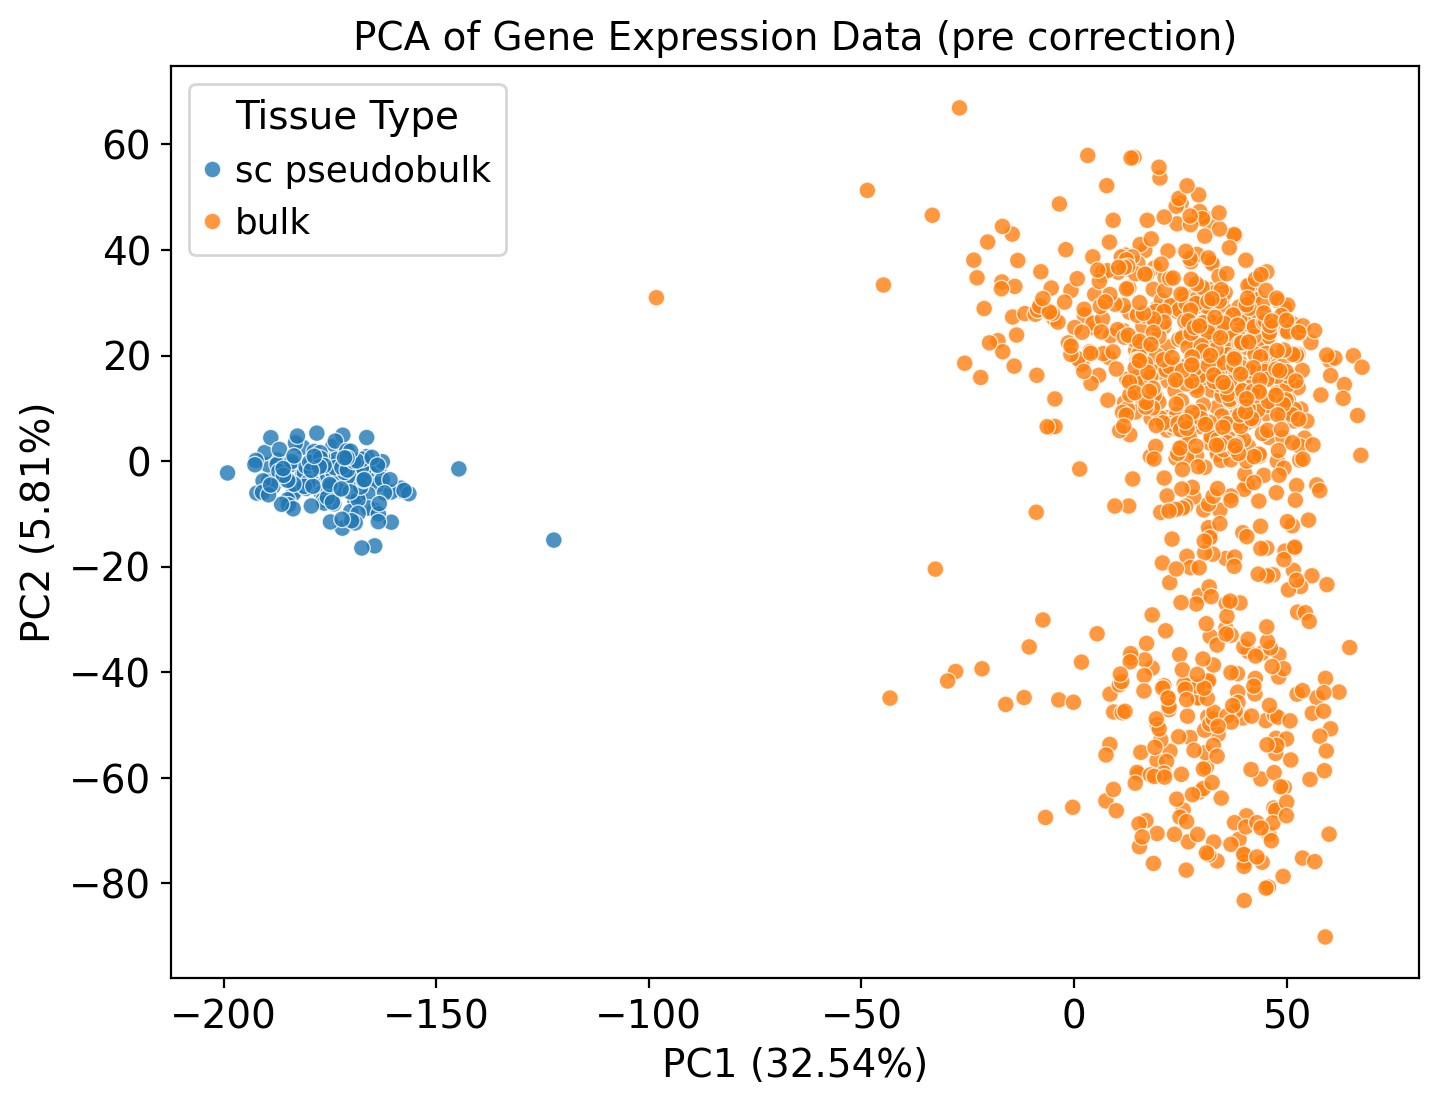

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the dataset
scaler = StandardScaler()
scaled_C_df = scaler.fit_transform(dataset_C.iloc[:, :-2])

# Perform PCA
pca = PCA(n_components=2)
pc_transformed = pca.fit_transform(scaled_C_df)

# Compute variance explained in percentage
explained_variance = pca.explained_variance_ratio_ * 100

# Create DataFrame with labeled PCs including variance explained
df_pca = pd.DataFrame(pc_transformed, columns=[f"PC{i+1} ({var:.2f}%)" for i, var in enumerate(explained_variance)])

# Reset index for merging with dataset_C
df_pca = df_pca.reset_index(drop=True)
dataset_C = dataset_C.reset_index(drop=True)

# Add back the "type" column
df_pca["type"] = dataset_C["type"]

# Plot PCA with variance explained in axis labels
fig, ax = plt.subplots(figsize=(8,6))  
sns.scatterplot(data=df_pca, x=df_pca.columns[0], y=df_pca.columns[1], hue="type", alpha=0.8, ax=ax)
plt.title("PCA of Gene Expression Data (pre correction)")
plt.legend(title="Tissue Type")
plt.grid()
plt.show()


pdf_path = "/group/iorio/Raffaele/SCDRESP_data/data/pca_precorrection.pdf"

fig.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')

plt.close(fig)


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


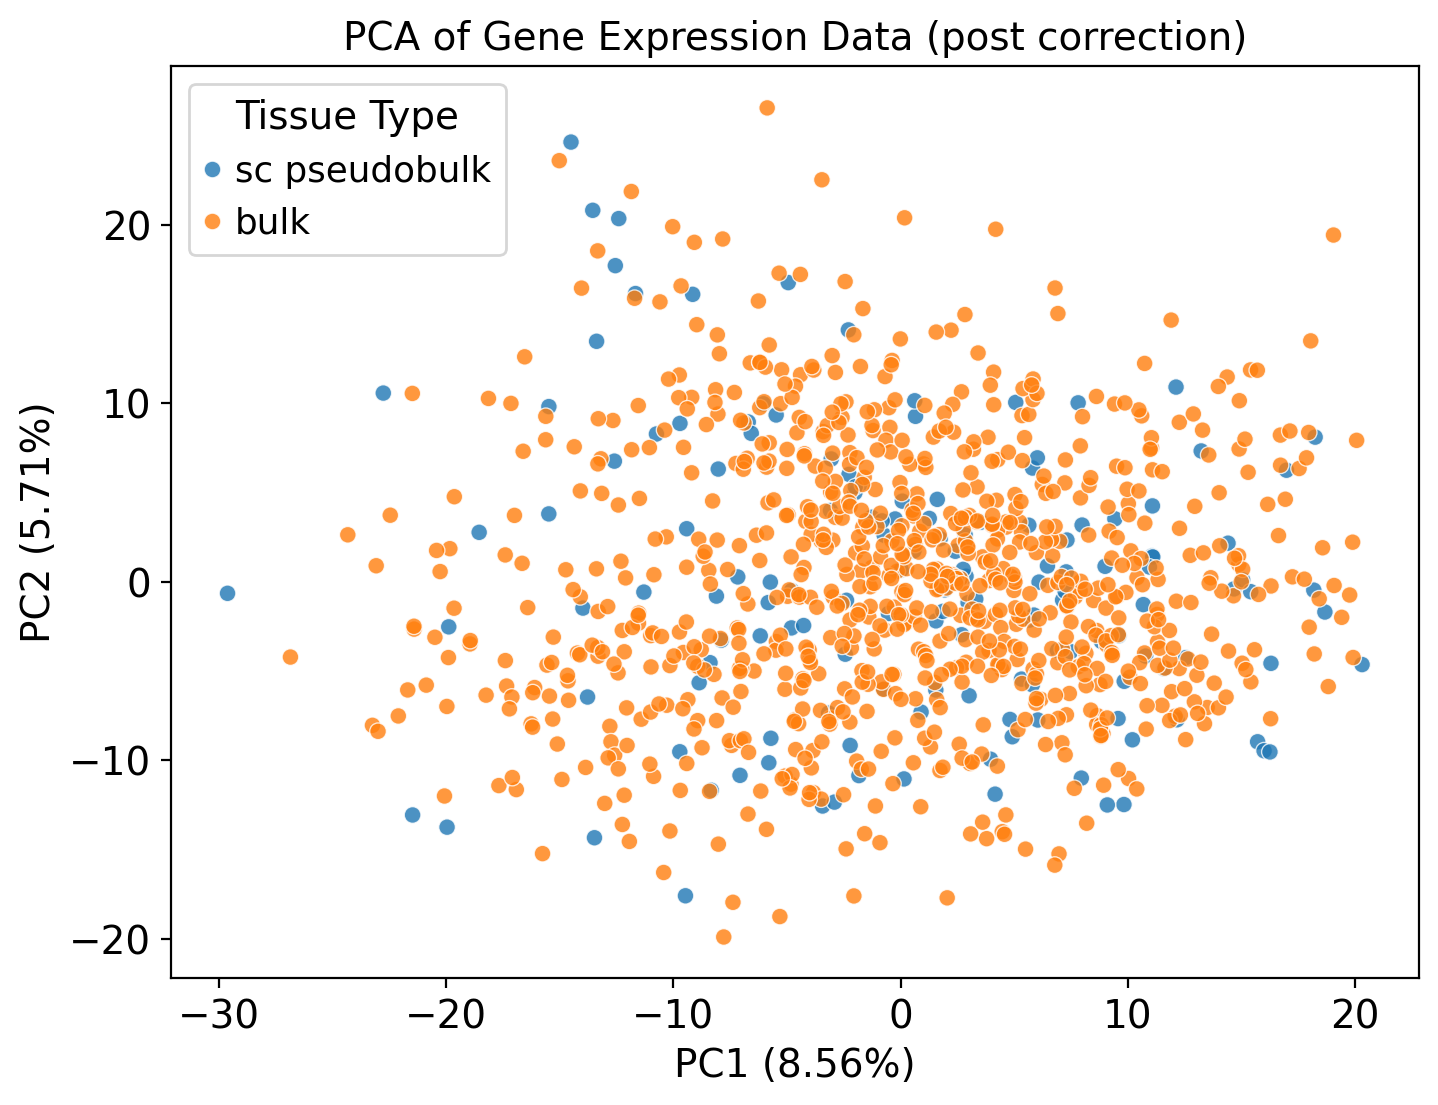

In [31]:
from combat.pycombat import pycombat
corrected = pycombat(dataset_C.iloc[:,:-2].T, dataset_C["type"])

scaler = StandardScaler()
scaled_corrected_df = scaler.fit_transform(corrected.T)

pca = PCA(n_components=2)
pc_transformed = pca.fit_transform(scaled_corrected_df.T)

# Compute variance explained in percentage
explained_variance = pca.explained_variance_ratio_ * 100

# Create DataFrame with labeled PCs including variance explained
df_pca = pd.DataFrame(pc_transformed, columns=[f"PC{i+1} ({var:.2f}%)" for i, var in enumerate(explained_variance)])

# Reset index for merging with dataset_C
df_pca = df_pca.reset_index(drop=True)
dataset_C = dataset_C.reset_index(drop=True)

df_pca["type"] = dataset_C["type"]

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df_pca, x=df_pca.columns[0], y=df_pca.columns[1], hue="type", alpha=0.8, ax=ax)
plt.title("PCA of Gene Expression Data (post correction)")
plt.legend(title="Tissue Type")
plt.grid()
plt.show()

pdf_path = "/group/iorio/Raffaele/SCDRESP_data/data/pca_postcorrection.pdf"
fig.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
plt.close(fig)



In [ ]:
corrected = corrected.T

In [ ]:
corrected["type"] = dataset_C["type"]
corrected["SangerModelID"] = dataset_C["SangerModelID"]

In [ ]:
gex_corrected = corrected[corrected["type"] == "bulk"]
gex_corrected = gex_corrected.drop(columns="type").reset_index(drop=True)
gex_corrected["OncotreeSubtype"] = gex_extended["OncotreeSubtype"]
gex_corrected = gex_corrected.reset_index(drop=True)

In [ ]:
gex_corrected

In [ ]:
drugs = {'AZD5153',
 'AZD5991',
 'AZD6738',
 'Crizotinib',
 'Dasatinib',
 'Gefitinib',
 'Lapatinib',
 'MK-2206',
 'Palbociclib',
 'Savolitinib',
 'Selumetinib',
 'Trametinib',
 'Venetoclax'}

In [ ]:
CLs_from_gex = set(gex_corrected["SangerModelID"].unique()) 
GENES = gex_corrected.drop(columns="SangerModelID").columns

training_sets_dict = {}

for dname in drugs:
    dresp_sub_df = gdsc[gdsc["DRUG_NAME"] == dname]
    CLs_from_dresp = set(dresp_sub_df["SangerModelID"].unique())
    CLs_to_keep = CLs_from_dresp & CLs_from_gex 
    dresp_filtered = dresp_sub_df[dresp_sub_df["SangerModelID"].isin(CLs_to_keep)]
    gex_filtered = gex_corrected[gex_corrected["SangerModelID"].isin(CLs_to_keep)]
    df = gex_filtered.merge(dresp_filtered, on="SangerModelID", how="left")
    ctype_counts = df["OncotreeSubtype"].value_counts()
    ctype_counts = ctype_counts[ctype_counts > 10].index # select ctype with at least 10 cell lines each
    df = df[df["OncotreeSubtype"].isin(ctype_counts)]
    SAMPLES = df["SangerModelID"].reset_index(drop=True)
    GEX=df.loc[:,df.columns.isin(GENES)].reset_index(drop=True)
    RESP=df["LN_IC50"].reset_index(drop=True)
    META=df[["OncotreeSubtype","CELL_LINE_NAME","PATHWAY_NAME","COSMIC_ID"]].reset_index(drop=True)
    training_sets_dict[dname] = {"OBS":SAMPLES, "X":GEX, "Y":RESP, "Metadata":META}  

In [ ]:
ncols = 3  
nrows = math.ceil(len(training_sets_dict) / ncols)  
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 25))
axes = axes.flatten()
for idx, (drug, data) in enumerate(training_sets_dict.items()):
    df = data["Metadata"]["OncotreeSubtype"]
    sns.barplot(x=df.value_counts().index, y=df.value_counts().values, ax=axes[idx])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha="right", fontsize=12)
    axes[idx].tick_params(axis="y", labelsize=12)
    axes[idx].set_title(f"{drug}; nr of cell lines: {len(data['OBS'])}", fontsize=14)

for idx in range(len(drugs), len(axes)):
    axes[idx].set_visible(False)  

plt.subplots_adjust(hspace=0.8, wspace=0.5)

plt.tight_layout()
plt.show()

In [ ]:
perc = 90
ncols = 3  
nrows = math.ceil(len(training_sets_dict) / ncols)  
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 25))
axes = axes.flatten()
for idx, (drug, data) in enumerate(training_sets.items()):
    df = data["Metadata"]["OncotreeSubtype"]
    threshold = np.percentile(df.value_counts(), perc)
    counts_df = df.value_counts().reset_index()
    counts_df.columns = ["Subtype", "Count"]
    counts_df["Class"] = np.nan
    counts_df.loc[counts_df["Count"] >= threshold, "Class"] = "over"
    counts_df.loc[counts_df["Count"] < threshold, "Class"] = "down"
    sns.barplot(x=counts_df["Subtype"], y=counts_df["Count"], hue=counts_df["Class"], ax=axes[idx])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha="right", fontsize=12)
    axes[idx].tick_params(axis="y", labelsize=12)
    axes[idx].set_title(f"{drug}; nr of cell lines: {len(data['OBS'])}", fontsize=14)
for idx in range(len(drug), len(axes)):
    axes[idx].set_visible(False)  

plt.subplots_adjust(hspace=0.8, wspace=0.5)

plt.tight_layout()
plt.show()

In [ ]:
#for idx, (drug, data) in enumerate(training_sets.items()):
#    df = data["Metadata"]["OncotreeSubtype"]
#    threshold = np.percentile(df.value_counts(), perc)
#    counts_df = df.value_counts().reset_index()
#    counts_df.columns = ["Subtype", "Count"]
#    counts_df["Class"] = np.where(counts_df["Count"] >= threshold, "over", "down")
#    training_sets[drug]["Metadata"] = training_sets[drug]["Metadata"].copy()  
#    training_sets[drug]["Metadata"]["Class"] = df.map(counts_df.set_index("Subtype")["Class"])

In [ ]:
def CategorizeOTS(data_dict, perc=90, plot_figure=True):
    
    import numpy as np
    import math
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    ncols = 3
    nrows = math.ceil(len(data_dict) / ncols)  
    
    if plot_figure:
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 25))
        axes = axes.flatten()
    
    for idx, (drug, data) in enumerate(data_dict.items()):
        df = data["Metadata"]["OncotreeSubtype"]
        threshold = np.percentile(df.value_counts(), perc)
        counts_df = df.value_counts().reset_index()
        counts_df.columns = ["Subtype", "Count"]
        
        counts_df["Class"] = np.where(counts_df["Count"] >= threshold, "over", "down")

        data_dict[drug]["Metadata"] = data["Metadata"].copy()  
        data_dict[drug]["Metadata"]["Class"] = df.map(counts_df.set_index("Subtype")["Class"])

        if plot_figure:
            sns.barplot(x=counts_df["Subtype"], y=counts_df["Count"], hue=counts_df["Class"], ax=axes[idx])
            axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha="right", fontsize=12)
            axes[idx].tick_params(axis="y", labelsize=12)
            axes[idx].set_title(f"{drug}; nr of cell lines: {len(data['OBS'])}", fontsize=14)

    if plot_figure:
        for idx in range(len(data_dict), len(axes)):
            axes[idx].set_visible(False)

        plt.subplots_adjust(hspace=0.8, wspace=0.5)
        plt.tight_layout()
        plt.show()

In [ ]:
CategorizeOTS(training_sets_dict,90)

In [ ]:
def DownsampleOTS(data_dict):
    
    import numpy as np
    import warnings
    from sklearn.utils import resample
    
    """
    Downsamples the 'over' class in the 'OncotreeSubtype' column to balance the dataset.
    """
    
    group_idx_downsampled = {}

    if not any("Class" in data["Metadata"].columns for data in data_dict.values()):
        warnings.warn("Column 'Class' is missing. Running CategorizeOTS() to categorize data.", UserWarning)
        CategorizeOTS(data_dict, plot_figure=False)

    for drug, data in data_dict.items():
        
        group_idx_downsampled[drug] = {}
        
        mdata = data["Metadata"]

        if "Class" not in mdata.columns:
            raise ValueError(f"Column 'Class' is still missing in metadata for {drug} after CategorizeOTS().")

        maj_class = mdata[mdata["Class"] == "over"].index
        min_class = mdata[mdata["Class"] == "down"].index

        # Extract corresponding metadata
        min_data = mdata.loc[min_class]
        maj_data = mdata.loc[maj_class]

        group_idx = maj_data.groupby("OncotreeSubtype").groups
        
        N = np.ceil(min_data["OncotreeSubtype"].value_counts().mean()).astype(int)
        
        # Downsample each group ensuring no errors when N > available samples
        group_idx_downsampled[drug] = {
            gn: resample(group, replace=False, n_samples=min(N.astype(int), len(group)), random_state=42)
            for gn, group in group_idx.items()
        }
    
    idx_dict = {k: [idx for i_v in v.values() for idx in i_v] for k, v in group_idx_downsampled.items()}
    return(idx_dict)


In [ ]:
def DownsampleOTS(data_dict):
    
    import numpy as np
    import warnings
    from sklearn.utils import resample
    
    """
    Downsamples the 'over' class in the 'OncotreeSubtype' column to balance the dataset.
    The number of retained samples in 'over' tissues is set to the mean count of 'down' tissues.

    Parameters:
    - data_dict (dict): Dictionary containing datasets with Metadata.

    Returns:
    - Updated data_dict with downsampled `Balanced_Metadata`, `Balanced_X`, `Balanced_Y`
    - Dictionary of downsampled indexes for tracking.
    """

    group_idx_downsampled = {}

    if not any("Class" in data["Metadata"].columns for data in data_dict.values()):
        warnings.warn("Column 'Class' is missing. Running CategorizeOTS() to categorize data.", UserWarning)
        CategorizeOTS(data_dict, plot_figure=False)  # Ensure tissues are classified before downsampling

    for drug, data in data_dict.items():
        
        group_idx_downsampled[drug] = {}
        
        mdata = data["Metadata"]

        if "Class" not in mdata.columns:
            raise ValueError(f"Column 'Class' is still missing in metadata for {drug} after CategorizeOTS().")

        maj_class = mdata[mdata["Class"] == "over"].index
        min_class = mdata[mdata["Class"] == "down"].index

        min_data = mdata.loc[min_class]
        maj_data = mdata.loc[maj_class]

        # Compute the mean sample count for downrepresented tissues
        N = int(min_data["OncotreeSubtype"].value_counts().mean())

        # Group overrepresented tissues by subtype
        group_idx = maj_data.groupby("OncotreeSubtype").groups

        downsampled_idx = list(min_class) 

        for tissue, indices in group_idx.items():
            if len(indices) > N:
                sampled_idx = resample(indices, n_samples=N, random_state=42, replace=False)
            else:
                sampled_idx = indices
            
            downsampled_idx.extend(sampled_idx)

        # Store the downsampled indexes for this drug
        group_idx_downsampled[drug] = downsampled_idx

        # Apply downsampling to the dataset
        data_dict[drug]["Balanced_Metadata"] = mdata.loc[downsampled_idx].copy()
        data_dict[drug]["Balanced_X"] = data["X"].loc[downsampled_idx].copy()
        data_dict[drug]["Balanced_Y"] = data["Y"].loc[downsampled_idx].copy()
        data_dict[drug]["Balanced_OBS"] = data['OBS'].loc[downsampled_idx].copy()

    return data_dict, group_idx_downsampled


In [ ]:
import numpy as np
import warnings
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

def BalanceOTS(data_dict, method="downsample", apply_smote=False, n_components=10):
    """
    Balances tissue representation in training datasets.

    Options:
    - Downsampling of overrepresented tissues to the mean of downrepresented tissues.
    - Stratified downsampling, preserving gene expression variance.
    - Optional SMOTE to oversample underrepresented tissues.

    Parameters:
    - data_dict (dict): Dictionary containing datasets with Metadata.
    - method (str): "downsample" (default) or "stratified" for stratified variance-based downsampling.
    - apply_smote (bool): If True, applies SMOTE to underrepresented tissues.
    - n_components (int): Number of PCA components to use for variance-based stratified downsampling.

    Returns:
    - Updated `data_dict` with:
        - Balanced_Metadata (metadata of downsampled set)
        - Balanced_X (gene expression data of balanced set)
        - Balanced_Y (drug response data of balanced set)
        - Balanced_OBS (indexes of selected cell lines)
    - Dictionary of selected indexes for each drug.
    """

    group_idx_balanced = {}

    # Check if classification exists
    if not any("Class" in data["Metadata"].columns for data in data_dict.values()):
        warnings.warn("Column 'Class' is missing. Running CategorizeOTS() to categorize data.", UserWarning)
        CategorizeOTS(data_dict, plot_figure=False)  # Ensure tissues are classified before balancing

    for drug, data in data_dict.items():
        group_idx_balanced[drug] = {}
        mdata = data["Metadata"]

        # Ensure classification column exists
        if "Class" not in mdata.columns:
            raise ValueError(f"Column 'Class' is missing in metadata for {drug} after CategorizeOTS().")

        # Identify overrepresented and downrepresented tissue indices
        maj_class = mdata[mdata["Class"] == "over"].index
        min_class = mdata[mdata["Class"] == "down"].index

        # Extract metadata
        min_data = mdata.loc[min_class]
        maj_data = mdata.loc[maj_class]

        # Compute `N`: Average number of samples in downrepresented tissues
        N = int(min_data["OncotreeSubtype"].value_counts().mean())

        # Group overrepresented tissues by subtype
        group_idx = maj_data.groupby("OncotreeSubtype").groups

        balanced_idx = list(min_class)  # Keep all downrepresented samples

        if method == "downsample":
            # 🔹 Basic Downsampling: Keep `N` samples per overrepresented tissue
            for tissue, indices in group_idx.items():
                sampled_idx = resample(indices, n_samples=min(N, len(indices)), random_state=42, replace=False)
                balanced_idx.extend(sampled_idx)

        elif method == "stratified":
            # 🔹 Stratified Downsampling: Keep `N` samples per overrepresented tissue while preserving variance
            pca = PCA(n_components=n_components)
            pca_fit = pca.fit_transform(data["X"])

            for tissue, indices in group_idx.items():
                if len(indices) > N:
                    # Rank by PCA variance and keep highest N
                    tissue_variances = np.var(pca_fit[indices], axis=1)
                    selected_idx = np.argsort(tissue_variances)[-N:]
                    sampled_idx = np.array(indices)[selected_idx]
                else:
                    sampled_idx = indices  # Keep as is if already <= N
                balanced_idx.extend(sampled_idx)

        # Store downsampled indexes for this drug
        group_idx_balanced[drug] = balanced_idx

        # Apply downsampling to the dataset
        data_dict[drug]["Balanced_Metadata"] = mdata.loc[balanced_idx].copy()
        data_dict[drug]["Balanced_X"] = data["X"].loc[balanced_idx].copy()
        data_dict[drug]["Balanced_Y"] = data["Y"].loc[balanced_idx].copy()
        data_dict[drug]["Balanced_OBS"] = data["OBS"].loc[balanced_idx].copy()

        if apply_smote:
            # 🔹 Apply SMOTE only to underrepresented tissues
            smote = SMOTE(sampling_strategy="auto", random_state=42)
            try:
                X_resampled, Y_resampled = smote.fit_resample(data_dict[drug]["Balanced_X"], data_dict[drug]["Balanced_Y"])
                data_dict[drug]["Balanced_X"] = X_resampled
                data_dict[drug]["Balanced_Y"] = Y_resampled
            except ValueError:
                warnings.warn(f"SMOTE failed for {drug} due to insufficient samples. Skipping SMOTE.")

    return data_dict, group_idx_balanced

In [ ]:
from sklearn.utils import resample
data = training_sets_dict["Gefitinib"]["Metadata"]
maj_class = data[data["Class"] == "over"].index
min_class = data[data["Class"] == "down"].index
min_data=data[data.index.isin(min_class)]
maj_data=data[data.index.isin(maj_class)]
MU_min=np.ceil(min_data["OncotreeSubtype"].value_counts().mean()).astype(int)
MU_maj=np.ceil(maj_data["OncotreeSubtype"].value_counts().mean()).astype(int)
N = MU_maj MU_min

In [ ]:
group_idx_downsampled = {}
group_idx = maj_data.groupby("OncotreeSubtype").groups
group_idx_downsampled = {gn: resample(group, replace=False, n_samples=N, random_state=42) for gn, group in group_idx.items()}
group_idx_downsampled = [idx for sublist in group_idx_downsampled.values() for idx in sublist]

In [ ]:
resampled_training_dict = {}
for drug, data in training_sets_dict.items():
    LEFTOVER=data["OBS"][data["OBS"].index.isin(test[drug])]
    SAMPLES=data["OBS"][~data["OBS"].index.isin(test[drug])]
    GEX=data["X"][~data["X"].index.isin(test[drug])]
    RESP=data["Y"][~data["Y"].index.isin(test[drug])]
    META=data["Metadata"][~data["Metadata"].index.isin(test[drug])]
    resampled_training_dict[drug] = {"LEFT":LEFTOVER, "OBS":SAMPLES, "X":GEX, "Y":RESP, "Metadata":META}  # i leftover gli injectiamo quando traininamo dentro l'inner loop?

In [ ]:
CategorizeOTS(resampled_training_dict)

In [ ]:
import random
from sklearn.model_selection import train_test_split

over_class = ["Lung Adenocarcinoma", "Small Cell Lung Cancer", "Colon Adenocarcinoma"]

downsampled_data_dict = {}

X_data = training_sets["AZD6738"]["X"]
Y_data = training_sets["AZD6738"]["Y"]

dat_ots = training_sets["AZD6738"]["Metadata"]["OncotreeSubtype"]

for t in over_class:
    sub_ots = dat_ots[(dat_ots == t)]
    K = int(np.ceil(len(sub_ots)/2))
    random.seed(42)
    idx_sampled = random.sample(list(sub_ots.index),K)
    X_data = X_data[~X_data.index.isin(idx_sampled)]
    Y_data = Y_data[~Y_data.index.isin(idx_sampled)]
    #X = X_data.fillna(0).to_numpy()
    #Y = Y_data.fillna(Y_data.mean()).to_numpy()
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
    
    print(f"X train:{X_train.shape}, " f"X_test:{X_test.shape}, " f"Y_train:{Y_train.shape}, "f"Y_test:{Y_test.shape}")

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
outer = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Dictionary to store trained models & scores
models = {}

# Define number of folds for nested cross-validation
n_outer_folds = 5  # Outer loop for model evaluation
n_inner_folds = 5  # Inner loop for hyperparameter tuning

# Outer cross-validation loop
kf_outer = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)

for dname, data in training_sets.items():
    print(f"Training LASSO model with Nested CV for {dname}...")
    for t in over_class:
        sub_ots = dat_ots[(dat_ots == t)]
        K = int(np.ceil(len(sub)/2))
        random.seed(42)
        idx_sampled = random.sample(list(sub_ots.index),K)
        X_data = X_data[~X_data.index.isin(idx_sampled)]
        Y_data = Y_data[~Y_data.index.isin(idx_sampled)]
        X = X_data.fillna(0).to_numpy()
        Y = Y_data.fillna(Y_data.mean()).to_numpy()

        # Outer loop: Perform k-fold cross-validation
        outer_r2_scores = []
        outer_rmse_scores = []
    
        for train_idx, test_idx in kf_outer.split(X, Y): 
            # Split dataset into train-test sets
            X_train, X_test = X[train_idx], X[test_idx]
            Y_train, Y_test = Y[train_idx], Y[test_idx]

            # Normalize features using training data statistics
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)  # Use same scaling for test data

            # Inner loop: Perform hyperparameter tuning within the training set
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)
            lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 50), cv=kf_inner, random_state=42, n_jobs=-1)
            lasso_cv.fit(X_train_scaled, Y_train)
            best_alpha = lasso_cv.alpha_

        # Train final model with best alpha on the entire training set
            final_model = LassoCV(alphas=[best_alpha], cv=5, random_state=42)
            final_model.fit(X_train_scaled, Y_train)

        # Predict on the test set
        Y_pred = final_model.predict(X_test_scaled)

        # Evaluate model
        mse = mean_squared_error(Y_test, Y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(Y_test, Y_pred)

        # Store outer fold scores
        outer_r2_scores.append(r2)
        outer_rmse_scores.append(rmse)

    # Store model, weights, and scaler parameters
    models[dname] = {
        "coef": final_model.coef_,
        "intercept": final_model.intercept_,
        "scaler_mean": scaler.mean_,
        "scaler_scale": scaler.scale_,
        "best_alpha": best_alpha,
        "outer_r2_scores": outer_r2_scores,
        "mean_r2": np.mean(outer_r2_scores),
        "std_r2": np.std(outer_r2_scores),
        "outer_rmse_scores": outer_rmse_scores,
        "mean_rmse": np.mean(outer_rmse_scores),
        "std_rmse": np.std(outer_rmse_scores),
    }

    # Save model
    with open(f"lasso_model_{dname}.pkl", "wb") as f:
        pickle.dump(models[dname], f)

    # Print results
    print(f"{dname}: Mean R² = {np.mean(outer_r2_scores):.4f} ± {np.std(outer_r2_scores):.4f} | "
          f"Mean RMSE = {np.mean(outer_rmse_scores):.4f} ± {np.std(outer_rmse_scores):.4f} | Best Alpha: {best_alpha:.4f}")

print("\nTraining complete for all drugs!")


In [ ]:
import pickle
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Dictionary to store trained models & scores
models = {}

# Define number of folds for cross-validation

outer = KFold(n_splits=5, shuffle=True, random_state=42)

for dname, data in training_sets.items():
    
    print(f"Training LASSO model with Nested CV for {dname}...")
    
    X = data["X"].fillna(0).to_numpy()
    Y = data["Y"].fillna(Y.mean()).to_numpy()
    
    # Split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
    
    # Standardize features
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Inner loop for hyperparameter tuning (runs in parallel)
    lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 50), cv=5, random_state=42, n_jobs=-1)

    # Perform nested cross-validation
    r2_scores = cross_val_score(lasso_cv, X_scaled, Y, scoring='r2', cv=outer, n_jobs=-1)
    rmse_scores = np.sqrt(-cross_val_score(lasso_cv, X_scaled, Y, scoring='neg_mean_squared_error', cv=outer, n_jobs=-1))

    # Train final model on full dataset
    lasso_cv.fit(X_scaled, Y)
    best_alpha = lasso_cv.alpha_

    # Store model, weights, and scaler parameters
    models[dname] = {
        "coef": lasso_cv.coef_,
        "intercept": lasso_cv.intercept_,
        "scaler_mean": scaler.mean_,
        "scaler_scale": scaler.scale_,
        "best_alpha": best_alpha,
        "cv_r2_scores": r2_scores,
        "mean_r2": np.mean(r2_scores),
        "std_r2": np.std(r2_scores),
        "cv_rmse_scores": rmse_scores,
        "mean_rmse": np.mean(rmse_scores),
        "std_rmse": np.std(rmse_scores),
    }

    # Save model
    with open(f"lasso_model_{dname}.pkl", "wb") as f:
        pickle.dump(models[dname], f)

    print(f"{dname}: Mean R² = {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f} | "
          f"Mean RMSE = {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f} | Best Alpha: {best_alpha:.4f}")

print("\nComplete!")
